# A simple yet extensible NPZD Slab model implemented with xarray-simlab

Benoit Bovy, January 2020.

In [23]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint

## Create process classes

### Common

In [24]:
@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    
    # for indexing xarray IO objects
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days

### Forcing environment

In [25]:
@xs.process
class BasicPeriodicForcing:
    time = xs.foreign(Time, 'days')
    
    mld = xs.variable(
        dims='time',
        intent='out',
        description='mixed layer depth'
    )
    
    mld_change = xs.variable(
        dims='time',
        intent='out',
        description='mixed layer depth change per time unit'
    )
    
    par = xs.variable(
        dims='time',
        intent='out',
        description='???'
    )
    
    sst = xs.variable(
        dims='time',
        intent='out',
        description='sea surface temperature'
    )
    
    def initialize(self):
        self.mld = np.cos(self.time/365*np.pi*2) * 100 + 200
        self.par = np.sin(self.time/365*np.pi) * 50 + 0
        self.sst = np.sin(self.time/365*np.pi) * 10 + 10
        
        dt = np.ediff1d(self.time, to_end=1)
        self.mld_change = np.gradient(self.mld) / dt
    

### Ecosystem components

In [26]:
@xs.process
class Component:
    """Base class for a component of a ecosystem."""

    label = xs.variable(groups='c_labels', description='component label')
    
    c0 = xs.variable(
        # only slab model (scalar)
        dims=(), 
        # support slab + 2D models ?
        #dims=[(), ('lat', 'lon')],
        groups='c_c0',
        description='inital concentration'
    )

In [27]:
@xs.process
class Nutrients(Component):

    label = xs.variable(
        default='N',
        groups='c_labels',
        description='nutrients label'
    )
    
    k = xs.variable(
        default=0.85,
        description='half saturation constant'
    )
    
    cb = xs.variable(
        default=15.0,
        description='concentration below mixed layer depth'
    )
    

@xs.process
class Phytoplankton(Component):

    label = xs.variable(
        default='P',
        groups='c_labels',
        description='phytoplankton label'
    )
    
    m = xs.variable(
        default=0.2,
        description='mortality rate'
    )
        

@xs.process
class Zooplankton(Component):

    label = xs.variable(
        default='Z',
        groups='c_labels',
        description='zooplankton label'
    )
    
    k = xs.variable(
        default=0.6,
        description='half saturation constant'
    )
    
    kn = xs.variable(
        default=0.75,
        description='net production efficiency'
    )
    
    beta = xs.variable(
        default=0.69,
        description='absorption efficiency'
    )
    
    m = xs.variable(
        default=0.1,
        description='mortality rate'
    )
    
    m2 = xs.variable(
        default=0.34,
        description='mortality rate (closure)'
    )


@xs.process
class Detritus(Component):

    label = xs.variable(
        default='D',
        groups='c_labels',
        description='detritus label'
    )
    
    m = xs.variable(
        default=0.6,
        description='remineralisation rate'
    )

In [28]:
print(Detritus)

<class '__main__.Detritus'>


In [29]:
@xs.process
class AllComponents:
    """Group some component propreties as 1-d arrays."""
    
    c_labels = xs.group('c_labels')
    c_c0 = xs.group('c_c0')
    
    labels = xs.variable(
        dims='component',
        intent='out',
        description='component labels'
    )
    c0 = xs.variable(
        dims='component',
        intent='out',
        description='initial concentration'
    )
    
    # use component labels as xarray coordinate/index
    component = xs.index(
        dims='component',
        description='component label'
    )
    
    def initialize(self):
        self.labels = np.array(list(self.c_labels))
        self.component = self.labels
        self.c0 = np.array(list(self.c_c0), dtype=np.double)
    

### ODE terms
  

In [30]:
@xs.process
class ODETerm:
    """Base class for any term in the ODE system formed by
    the fluxes of each component in an ecosystem.
    
    The term is represented by a function of both time and
    the component concentrations at that time (even though
    the dependence of the actual expression on those
    quantities is optional).
    
    """

    func = xs.variable(intent='out', description='ODE term expression')
    
    def _func(self, state, time):
        """
        Parameters
        ----------
        state : dict
            Keys are ecosystem component labels and values are
            concentrations at current time.
        time : float
            Current time.

        """
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        self.func = self._func
        

In [31]:
@xs.process
class ForcingTerm(ODETerm):
    """Base class for all forcing terms.
    
    The common operation is here to retrieve the index of
    the 1-d array at the current time, and return the value
    at that index.

    """
    
    time = xs.foreign(Time, 'days')
    
    # to be replaced in subclass
    forcing_var = xs.variable()
    
    def _func(self, *args):
        _, t = args

        idx = np.argmax(t < self.time)
        return self.forcing_var[idx]
    

@xs.process
class MLD(ForcingTerm):
    forcing_var = xs.foreign(BasicPeriodicForcing, 'mld')


@xs.process
class MLDChange(ForcingTerm):
    forcing_var = xs.foreign(BasicPeriodicForcing, 'mld_change')
    

@xs.process
class PAR(ForcingTerm):
    forcing_var = xs.foreign(BasicPeriodicForcing, 'par')


@xs.process
class SST(ForcingTerm):
    forcing_var = xs.foreign(BasicPeriodicForcing, 'sst')


In [32]:
@xs.process
class Mixing(ODETerm):
    
    kappa = xs.variable(
        default=0.1,
        description='cross thermocline mixing'
    )
    
    mld = xs.foreign(MLD, 'func')
    mld_change = xs.foreign(MLDChange, 'func')
    
    def _func(self, *args):
        return (self.kappa + max(self.mld_change(*args), 0.)) / self.mld(*args)
    

@xs.process
class Uptake(ODETerm):
    
    n_label = xs.foreign(Nutrients, 'label')
    k_n = xs.foreign(Nutrients, 'k')
    
    def _func(self, *args):
        state, _ = args
        n = state[self.n_label]

        return n / (n + self.k_n)
    

@xs.process
class Grazing:

    max_rate = xs.variable(
        default=0.8,
        description='maximum ingestion rate'
    ) 
    
    pphyto = xs.variable(
        default=0.67,
        description='grazing preference for phytoplankton'
    )
    pdet = xs.variable(
        default=0.33,
        description='grazing preference for detritus'
    )
    
    @pdet.validator
    def _check_preference(self, attr, value):
        # pphyto + pdet == 1 must be True ???
        if value + self.pphyto != 1:
            raise ValueError


@xs.process
class GrazingBase(ODETerm):
    
    max_rate = xs.foreign(Grazing, 'max_rate')
    pphyto = xs.foreign(Grazing, 'pphyto')
    pdet = xs.foreign(Grazing, 'pdet')
    k_z = xs.foreign(Zooplankton, 'k')
    
    p_label = xs.foreign(Phytoplankton, 'label')
    d_label = xs.foreign(Detritus, 'label')
    
    @property
    def comp(self):
        raise NotImplementedError

    def _func(self, *args):
        state, _ = args

        pcomp = {
            'p': self.pphyto * state[self.p_label]**2,
            'd': self.pdet * state[self.d_label]**2
        }
        
        num = self.max_rate * pcomp[self.comp]
        den = self.k_z**2 + pcomp['p'] + pcomp['d']
        
        return num / den


@xs.process
class GrazingPhyto(GrazingBase):
    
    @property
    def comp(self):
        return 'p'
    

@xs.process
class GrazingDetritus(GrazingBase):
    
    @property
    def comp(self):
        return 'd'


@xs.process
class Light(ODETerm):
    
    v_max = xs.variable(
        default=1.1,
        description='maximum photosynthetic rate'
    )
    alpha = xs.variable(
        default=0.15,
        description='initial slope of P-I curve'
    )
    
    kw = xs.variable(
        default=0.05,
        description='extinction coefficient due to water'
    )
    kp = xs.variable(
        default=0.03,
        description='extinction coefficient due to phytoplankton'
    )
    
    p_label = xs.foreign(Phytoplankton, 'label')
    
    mld = xs.foreign(MLD, 'func')
    par = xs.foreign(PAR, 'func')
    
    def _func(self, *args):
        state, time = args
        
        p_term = self.kw + self.kp * state[self.p_label]
        mld = self.mld(*args)
        par = self.par(*args)

        iz = par * np.exp(-p_term * mld)
        psi = (self.v_max / (p_term * mld)) * np.log(
            (self.alpha * par + np.sqrt(self.v_max**2 + (self.alpha * par)**2)) /
            (self.alpha * iz + np.sqrt(self.v_max**2 + (self.alpha * iz)**2))
        )
        
        return psi

### Component fluxes

In [33]:
@xs.process
class ComponentFlux(ODETerm):
    """Base class for the expression of the flux of a
    component C, i.e., dC/dt.
    
    """

    # let's reuse the component label
    label = xs.foreign(Component, 'label')
    
    flux_label = xs.variable(
        intent='out',
        groups='c_flux_labels',
        description='for consistent building of the ODE system'
    )
    
    func = xs.variable(
        intent='out',
        groups='c_flux_funcs',
        description='component flux expression'
    )
    
    def initialize(self):
        self.flux_label = self.label
        
        super(ComponentFlux, self).initialize()


In [34]:
def temp(te): 
    E = np.exp(0.063*te)
    return E


@xs.process
class NutrientsFlux(ComponentFlux):
    
    label = xs.foreign(Nutrients, 'label')
    
    p_label = xs.foreign(Phytoplankton, 'label')
    z_label = xs.foreign(Zooplankton, 'label')
    d_label = xs.foreign(Detritus, 'label')
    
    n_cb = xs.foreign(Nutrients, 'cb')
    beta = xs.foreign(Zooplankton, 'beta')
    z_kn = xs.foreign(Zooplankton, 'kn')
    d_m = xs.foreign(Detritus, 'm')
    
    sst = xs.foreign(SST, 'func')
    mixing = xs.foreign(Mixing, 'func')
    uptake = xs.foreign(Uptake, 'func')
    light = xs.foreign(Light, 'func')
    grazing_p = xs.foreign(GrazingPhyto, 'func')
    grazing_d = xs.foreign(GrazingDetritus, 'func')
    
    def _func(self, *args):
        state, _ = args

        return (
            state[self.p_label] * (- temp(self.sst(*args)) * self.uptake(*args) * self.light(*args)) +
            state[self.z_label] * (self.beta * (1 - self.z_kn) * (self.grazing_p(*args) + self.grazing_d(*args))) +
            state[self.d_label] * self.d_m +
            (self.n_cb - state[self.label]) * self.mixing(*args)
        )
    
    
@xs.process
class PhytoplanktonFlux(ComponentFlux):
    
    label = xs.foreign(Phytoplankton, 'label')
    
    z_label = xs.foreign(Zooplankton, 'label')
    
    p_m = xs.foreign(Phytoplankton, 'm')
    
    sst = xs.foreign(SST, 'func')
    mixing = xs.foreign(Mixing, 'func')
    uptake = xs.foreign(Uptake, 'func')
    light = xs.foreign(Light, 'func')
    grazing_p = xs.foreign(GrazingPhyto, 'func')
    
    def _func(self, *args):
        state, _ = args

        return (
            state[self.label] * (temp(self.sst(*args)) * self.uptake(*args) * self.light(*args)) -
            state[self.label] * self.p_m -
            state[self.z_label] * self.grazing_p(*args) -
            state[self.label] * self.mixing(*args)
        )
    

@xs.process
class ZooplanktonFlux(ComponentFlux):
    
    label = xs.foreign(Zooplankton, 'label')
    
    beta = xs.foreign(Zooplankton, 'beta')
    z_kn = xs.foreign(Zooplankton, 'kn')
    z_m = xs.foreign(Zooplankton, 'm')
    z_m2 = xs.foreign(Zooplankton, 'm2')
    
    mld = xs.foreign(MLD, 'func')
    mld_change = xs.foreign(MLDChange, 'func')
    grazing_p = xs.foreign(GrazingPhyto, 'func')
    grazing_d = xs.foreign(GrazingDetritus, 'func')
    
    def _func(self, *args):
        state, _ = args
        
        return (
            state[self.label] * self.beta * self.z_kn * (self.grazing_p(*args) + self.grazing_d(*args)) -
            state[self.label] * self.z_m -
            state[self.label]**2 * self.z_m2 -
            state[self.label] * (self.mld_change(*args) / self.mld(*args))
        )
    

@xs.process
class DetritusFlux(ComponentFlux):
    
    label = xs.foreign(Detritus, 'label')
    
    p_label = xs.foreign(Phytoplankton, 'label')
    z_label = xs.foreign(Zooplankton, 'label')
    
    beta = xs.foreign(Zooplankton, 'beta')
    p_m = xs.foreign(Phytoplankton, 'm')
    z_m = xs.foreign(Zooplankton, 'm')
    d_m = xs.foreign(Detritus, 'm')
    
    mixing = xs.foreign(Mixing, 'func')
    grazing_p = xs.foreign(GrazingPhyto, 'func')
    grazing_d = xs.foreign(GrazingDetritus, 'func')
    
    def _func(self, *args):
        state, _ = args
        
        return (
            state[self.p_label] * self.p_m +
            state[self.z_label] * self.z_m +
            state[self.z_label] * (1 - self.beta) * (self.grazing_p(*args) + self.grazing_d(*args)) -
            state[self.z_label] * self.grazing_d(*args) -
            state[self.label] * self.d_m -
            state[self.label] * self.mixing(*args)
        )


### Slab main process (build and solve the ODE system of fluxes) 

In [35]:
@xs.process
class Slab:
    time = xs.foreign(Time, 'time')
    
    c = xs.variable(
        dims=('time', 'component'),
        intent='out',
        description='component concentrations',
        attrs={'units': 'micromol N L^-1'}
    )
    
    labels = xs.foreign(AllComponents, 'labels')
    c0 = xs.foreign(AllComponents, 'c0')
    
    flux_labels = xs.group('c_flux_labels')
    flux_funcs = xs.group('c_flux_funcs')
    
    def initialize(self):
        # pick the right flux expression for each component
        funcs = {
            label: func
            for label, func in zip(self.flux_labels, self.flux_funcs)
        }

        def ode(c, t):
            state = {label: val for label, val in zip(self.labels, c)}
            return [funcs[label](state, t) for label in self.labels]
        
        self.c = odeint(
            ode,
            self.c0,
            self.time,
            rtol=1e-12,
            atol=1e-12
        )

## Create the NPZD model

In [36]:
npzd_model = xs.Model({
    # common
    'time': Time,
    # ecosystem components
    'n': Nutrients,
    'p': Phytoplankton,
    'z': Zooplankton,
    'd': Detritus,
    'components': AllComponents,
    # forcing
    'forcing': BasicPeriodicForcing,
    # ODE terms
    'mld': MLD,
    'mld_change': MLDChange,
    'par': PAR,
    'sst': SST,
    'mixing': Mixing,
    'uptake': Uptake,
    'grazing': Grazing,
    'grazing_phyto': GrazingPhyto,
    'grazing_detritus': GrazingDetritus,
    'light': Light,
    # component fluxes
    'n_flux': NutrientsFlux,
    'p_flux': PhytoplanktonFlux,
    'z_flux': ZooplanktonFlux,
    'd_flux': DetritusFlux,
    # ODE building and integration
    'slab': Slab
})

In [37]:
npzd_model

<xsimlab.Model (22 processes, 26 inputs)>
time
    days         [in] ('time',) time in days
n
    cb           [in] concentration below mixed layer depth
    k            [in] half saturation constant
    c0           [in] inital concentration
    label        [in] nutrients label
p
    m            [in] mortality rate
    label        [in] phytoplankton label
    c0           [in] inital concentration
z
    m            [in] mortality rate
    k            [in] half saturation constant
    kn           [in] net production efficiency
    c0           [in] inital concentration
    label        [in] zooplankton label
    beta         [in] absorption efficiency
    m2           [in] mortality rate (closure)
d
    c0           [in] inital concentration
    label        [in] detritus label
    m            [in] remineralisation rate
components
forcing
mld
mld_change
par
sst
mixing
    kappa        [in] cross thermocline mixing
uptake
grazing
    pdet         [in] grazing preference for detr

In [38]:
from graphviz import Digraph

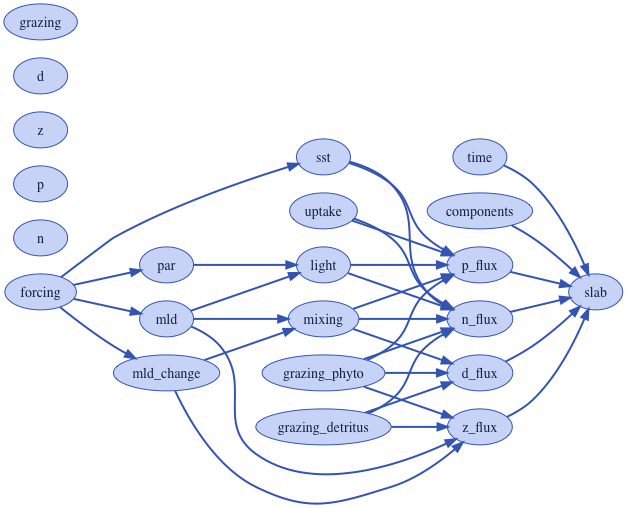

In [39]:
npzd_model.visualize()#show_inputs=True, show_variables=True)

## Setup and run the model

In [40]:
in_ds = xs.create_setup(
    model=npzd_model,
    clocks={'clock': [0, 1]},  # not used but required
    input_vars={
        'time__days': ('time', np.arange(0, 366)),
        'n__c0': 15.0,
        'p__c0': 0.01,
        'z__c0': 0.01,
        'd__c0': 0.01,
    },
    output_vars={
        'slab__c': None,  # None is meaningless here but required
    }
)

In [41]:
%timeit in_ds.xsimlab.run(model=npzd_model)

10.9 s ± 869 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
out_ds = in_ds.xsimlab.run(model=npzd_model)

out_ds

<xarray.Dataset>
Dimensions:            (clock: 2, component: 4, time: 366)
Coordinates:
  * clock              (clock) int64 0 1
  * component          (component) <U1 'N' 'P' 'Z' 'D'
  * time               (time) int64 0 1 2 3 4 5 6 ... 360 361 362 363 364 365
Data variables:
    d__c0              float64 0.01
    d__label           <U1 'D'
    d__m               float64 0.6
    grazing__max_rate  float64 0.8
    grazing__pdet      float64 0.33
    grazing__pphyto    float64 0.67
    light__alpha       float64 0.15
    light__kp          float64 0.03
    light__kw          float64 0.05
    light__v_max       float64 1.1
    mixing__kappa      float64 0.1
    n__c0              float64 15.0
    n__cb              float64 15.0
    n__k               float64 0.85
    n__label           <U1 'N'
    p__c0              float64 0.01
    p__label           <U1 'P'
    p__m               float64 0.2
    slab__c            (time, component) float64 15.0 0.01 ... 0.002407 0.004502
    time__days         (time) int64 0 1 2 3 4 5 6 ... 360 361 362 363 364 365
    z__beta            float64 0.69
    z__c0              float64 0.01
    z__k               float64 0.6
    z__kn              float64 0.75
    z__label           <U1 'Z'
    z__m               float64 0.1
    z__m2              float64 0.34

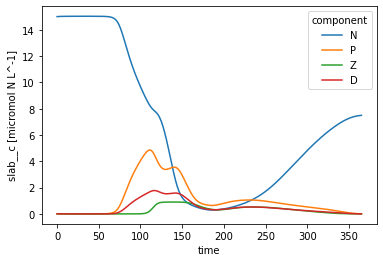

In [43]:
out_ds.slab__c.plot.line(x='time');

In [44]:
out_ds.slab__c

<xarray.DataArray 'slab__c' (time: 366, component: 4)>
array([[1.50000000e+01, 1.00000000e-02, 1.00000000e-02, 1.00000000e-02],
       [1.50051446e+01, 8.24630956e-03, 9.02091716e-03, 7.55160339e-03],
       [1.50090331e+01, 6.85305851e-03, 8.14080829e-03, 5.90599548e-03],
       ...,
       [7.48060306e+00, 1.23163033e-02, 2.94495685e-03, 6.35501258e-03],
       [7.48727877e+00, 1.01521763e-02, 2.66220017e-03, 5.36370183e-03],
       [7.49310639e+00, 8.30842977e-03, 2.40684594e-03, 4.50161051e-03]])
Coordinates:
  * component  (component) <U1 'N' 'P' 'Z' 'D'
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364 365
Attributes:
    description:  component concentrations
    units:        micromol N L^-1
    _FillValue:   nan